# Data Cleaning

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## Load data

In [2]:
train_path = "data/claims_train.csv"
test_path  = "data/claims_test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Test  shape:", df_test.shape)

df_train.head()


Train shape: (542410, 12)
Test  shape: (135603, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
1,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
2,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
3,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
4,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


## Quick schema + missing values

In [3]:
def quick_schema(df, name="df"):
    print(f"\n=== {name} ===")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isna().sum().sort_values(ascending=False).head(20))

quick_schema(df_train, "train")
quick_schema(df_test,  "test")


=== train ===
IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

Missing values:
IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

=== test ===
IDpol           int64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

Missing values:
IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0


## Basic integrity checks (unique IDs, duplicates)

In [4]:
def id_checks(df, name="df"):
    if "IDpol" in df.columns:
        n = len(df)
        nunique = df["IDpol"].nunique()
        dup = df.duplicated(subset=["IDpol"]).sum()
        print(f"\n{name}: rows={n}, unique IDpol={nunique}, duplicated IDpol rows={dup}")

id_checks(df_train, "train")
id_checks(df_test,  "test")



train: rows=542410, unique IDpol=542410, duplicated IDpol rows=0

test: rows=135603, unique IDpol=135603, duplicated IDpol rows=0


## Find duplicates excluding IDPol

In [5]:
import pandas as pd

# Load data
df = pd.read_csv("data/claims_train.csv")

# Identify duplicates ignoring IDPol
dup_mask = df.drop(columns=["IDpol"]).duplicated(keep=False)

# Number of duplicated rows*
num_dups = dup_mask.sum()
print(f"Number of duplicated rows (excluding IDpol): {num_dups}")


Number of duplicated rows (excluding IDpol): 29792


## Inspect duplicated entries

In [6]:
df_duplicates = df[dup_mask].sort_values(by=df.columns.tolist())

df_duplicates.head(10)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
155536,1187.0,1,0.09,D,5,0,44,50,B12,Regular,665,R41
354877,1189.0,1,0.09,D,5,0,44,50,B12,Regular,665,R41
258555,1957.0,1,0.75,E,10,10,34,100,B1,Regular,6570,R11
457662,2707.0,1,0.75,E,10,10,34,100,B1,Regular,6570,R11
230512,3349.0,1,0.47,E,4,0,51,50,B12,Regular,2580,R72
298625,3351.0,1,0.47,E,4,0,51,50,B12,Regular,2580,R72
284097,3494.0,1,0.07,C,7,0,72,50,B12,Regular,122,R93
223606,3495.0,1,0.07,C,7,0,72,50,B12,Regular,122,R93
494820,4981.0,1,0.03,E,6,0,51,72,B12,Regular,4059,R23
169072,4984.0,1,0.03,E,6,0,51,72,B12,Regular,4059,R23


In [7]:
duplicate_groups = (
    df_duplicates
    .drop(columns=["IDpol"])
    .value_counts()
    .reset_index(name="count")
)

duplicate_groups.head()


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,count
0,0,0.66,B,9,3,35,64,B2,Regular,92,R72,18
1,0,0.21,E,6,11,31,50,B2,Diesel,4348,R72,13
2,0,0.07,E,7,9,27,76,B1,Diesel,4116,R24,13
3,0,0.08,C,4,2,53,50,B2,Regular,182,R72,11
4,0,0.08,D,5,1,67,50,B2,Diesel,1466,R31,11


## Remove duplicates excluding IDPol

In [8]:
df_cleaned = df.drop_duplicates(
    subset=[c for c in df.columns if c != "IDpol"],
    keep="first"
)

print(f"Initial dataset size: {len(df)}")
print(f"After feature-level deduplication: {len(df_cleaned)}")

Initial dataset size: 542410
After feature-level deduplication: 521703


## Bar chart: initial vs cleaned dataset

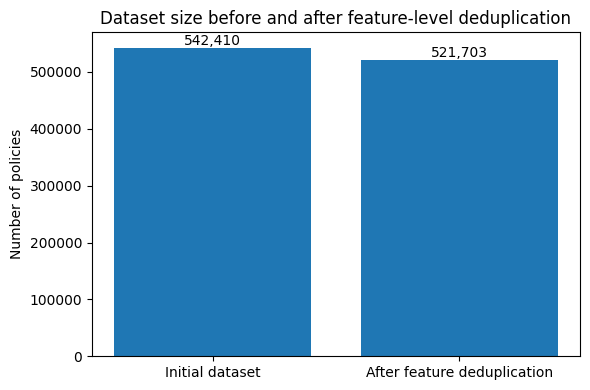

In [9]:
labels = ["Initial dataset", "After feature deduplication"]
values = [len(df), len(df_cleaned)]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.ylabel("Number of policies")
plt.title("Dataset size before and after feature-level deduplication")

for i, v in enumerate(values):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

plt.tight_layout()

# Save the figure
plt.savefig(
    "figures/dataset_size_feature_deduplication.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## Range checks

In [10]:
NUM_COLS = ["ClaimNb", "Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]

def range_report(df, name="df"):
    print(f"\n=== Range report: {name} ===")
    for c in NUM_COLS:
        if c in df.columns:
            print(f"{c:>10}: min={df[c].min()}  max={df[c].max()}")

range_report(df_train, "train")
range_report(df_test,  "test")



=== Range report: train ===
   ClaimNb: min=0  max=11
  Exposure: min=0.00273224  max=2.01
  VehPower: min=4  max=15
    VehAge: min=0  max=100
   DrivAge: min=18  max=100
BonusMalus: min=50  max=230
   Density: min=1  max=27000

=== Range report: test ===
   ClaimNb: min=0  max=16
  Exposure: min=0.00273224  max=1.9
  VehPower: min=4  max=15
    VehAge: min=0  max=100
   DrivAge: min=18  max=100
BonusMalus: min=50  max=190
   Density: min=1  max=27000


## Cleaning rules

Rules for this dataset:

- Exposure should be > 0

- Exposure ≤ 1 (since the scope is “last year”)

- ClaimNb should be integer ≥ 0

- Ages should be non-negative; driver age should be ≥ 18

- Density should be > 0

In [11]:
CLEANING_RULES = {
    "exposure_min": 0.0,     
    "exposure_max": 1.0,     # enforce because "last year"
    "claimnb_min": 0,
    "drivage_min": 18,
    "vehage_min": 0,
    "density_min": 0
}
CLEANING_RULES


{'exposure_min': 0.0,
 'exposure_max': 1.0,
 'claimnb_min': 0,
 'drivage_min': 18,
 'vehage_min': 0,
 'density_min': 0}

## Apply cleaning

In [12]:
def clean_claims_df(df, rules, exposure_mode="cap"):
    """
    exposure_mode:
      - "cap": cap Exposure to [>0, max]
      - "drop": drop rows outside (0, max]
    """
    df = df.copy()

    # Ensure numeric types where relevant
    for c in ["ClaimNb", "Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")    # Tries to convert values to numbers

    # Drop rows with NA introduced by coercion (should be rare)
    before = len(df)
    df = df.dropna()
    dropped_na = before - len(df)

    # ClaimNb: enforce integer >= 0
    df["ClaimNb"] = df["ClaimNb"].round().astype(int)
    df = df[df["ClaimNb"] >= rules["claimnb_min"]]

    # Exposure: enforce > 0
    df = df[df["Exposure"] > rules["exposure_min"]]

    # Exposure: handle > max
    if exposure_mode == "cap":
        df["Exposure"] = df["Exposure"].clip(upper=rules["exposure_max"])
    elif exposure_mode == "drop":
        df = df[df["Exposure"] <= rules["exposure_max"]]
    else:
        raise ValueError("exposure_mode must be 'cap' or 'drop'")

    # Ages and density sanity filters (conservative)
    df = df[df["VehAge"]  >= rules["vehage_min"]]
    df = df[df["DrivAge"] >= rules["drivage_min"]]
    df = df[df["Density"] >  rules["density_min"]]

    # Clean categorical columns (strip whitespace, consistent casing if needed)
    for c in ["Area", "VehBrand", "VehGas", "Region"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    cleaning_log = {
        "dropped_na_after_type_coercion": dropped_na,
        "final_rows": len(df),
    }
    return df, cleaning_log


df_train_clean, log_train = clean_claims_df(df_train, CLEANING_RULES, exposure_mode="cap")
df_test_clean,  log_test  = clean_claims_df(df_test,  CLEANING_RULES, exposure_mode="cap")

print("Train cleaning log:", log_train)
print("Test  cleaning log:", log_test)
print("Train shape after:", df_train_clean.shape)
print("Test  shape after:", df_test_clean.shape)


Train cleaning log: {'dropped_na_after_type_coercion': 0, 'final_rows': 542410}
Test  cleaning log: {'dropped_na_after_type_coercion': 0, 'final_rows': 135603}
Train shape after: (542410, 12)
Test  shape after: (135603, 12)


## Inspect what changed (exposure issues)

In [13]:
def count_exposure_over_1(df, name="df"):
    n = (df["Exposure"] > 1.0).sum()
    print(f"{name}: Exposure > 1.0 rows = {n}")

count_exposure_over_1(df_train, "raw train")
count_exposure_over_1(df_test,  "raw test")


raw train: Exposure > 1.0 rows = 994
raw test: Exposure > 1.0 rows = 230


## Save cleaned outputs for future usage

In [14]:
out_train = "data/claims_train_clean.csv"
out_test  = "data/claims_test_clean.csv"

df_train_clean.to_csv(out_train, index=False)
df_test_clean.to_csv(out_test, index=False)

print("Saved:", out_train)
print("Saved:", out_test)

Saved: data/claims_train_clean.csv
Saved: data/claims_test_clean.csv


## Final “cleaned data” sanity check

In [15]:
range_report(df_train_clean, "train_clean")
range_report(df_test_clean,  "test_clean")

df_train_clean.head()



=== Range report: train_clean ===
   ClaimNb: min=0  max=11
  Exposure: min=0.00273224  max=1.0
  VehPower: min=4  max=15
    VehAge: min=0  max=100
   DrivAge: min=18  max=100
BonusMalus: min=50  max=230
   Density: min=1  max=27000

=== Range report: test_clean ===
   ClaimNb: min=0  max=16
  Exposure: min=0.00273224  max=1.0
  VehPower: min=4  max=15
    VehAge: min=0  max=100
   DrivAge: min=18  max=100
BonusMalus: min=50  max=190
   Density: min=1  max=27000


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
1,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
2,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
3,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
4,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53
